# API Resignation Prevention

This notebook implements an example of how to predict if an employee will ask for their resignation in the future in order to empower HR to prepare themselves to prevent this.

### Dataset used: 
https://www.kaggle.com/jacksonchou/hr-data-for-analytics

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
employee_df = pd.read_csv("HR_comma_sep.csv")

In [3]:
#in this dataset 1 represents the people that left the company and 0 peoplo who stayed
employee_df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


In [4]:
#rename column to a more accurate name
employee_df.rename(columns={"sales":"department",
                            "average_montly_hours":"average_monthly_hours"},
                   inplace=True)

In [5]:
employee_df.shape

(14999, 10)

## Data Preparation

### Distribution of the entries

Analyzing the numbers here I can already notice that the feature work_accident and promotion_last_5years may not be very decisive in the prediction due to its low mean and its skewed distribuition.

In [6]:
employee_df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [7]:
#verify if variables contains missing values
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Rare Events

With the histogram we can notice that the company represented in this data doesn't have a lot of accidents(what is good) but a great indicator that we can discard this feature before the preprocessing.

Another variable that shows a very uneven distribution is promotion_last_5years.

But some questions remain, what if these accidents only occured with the people who left? And what if the promotion were only given to those who stayed? If so, it requires more investigation.

array([[<AxesSubplot:title={'center':'satisfaction_level'}>,
        <AxesSubplot:title={'center':'last_evaluation'}>,
        <AxesSubplot:title={'center':'number_project'}>],
       [<AxesSubplot:title={'center':'average_monthly_hours'}>,
        <AxesSubplot:title={'center':'time_spend_company'}>,
        <AxesSubplot:title={'center':'Work_accident'}>],
       [<AxesSubplot:title={'center':'left'}>,
        <AxesSubplot:title={'center':'promotion_last_5years'}>,
        <AxesSubplot:>]], dtype=object)

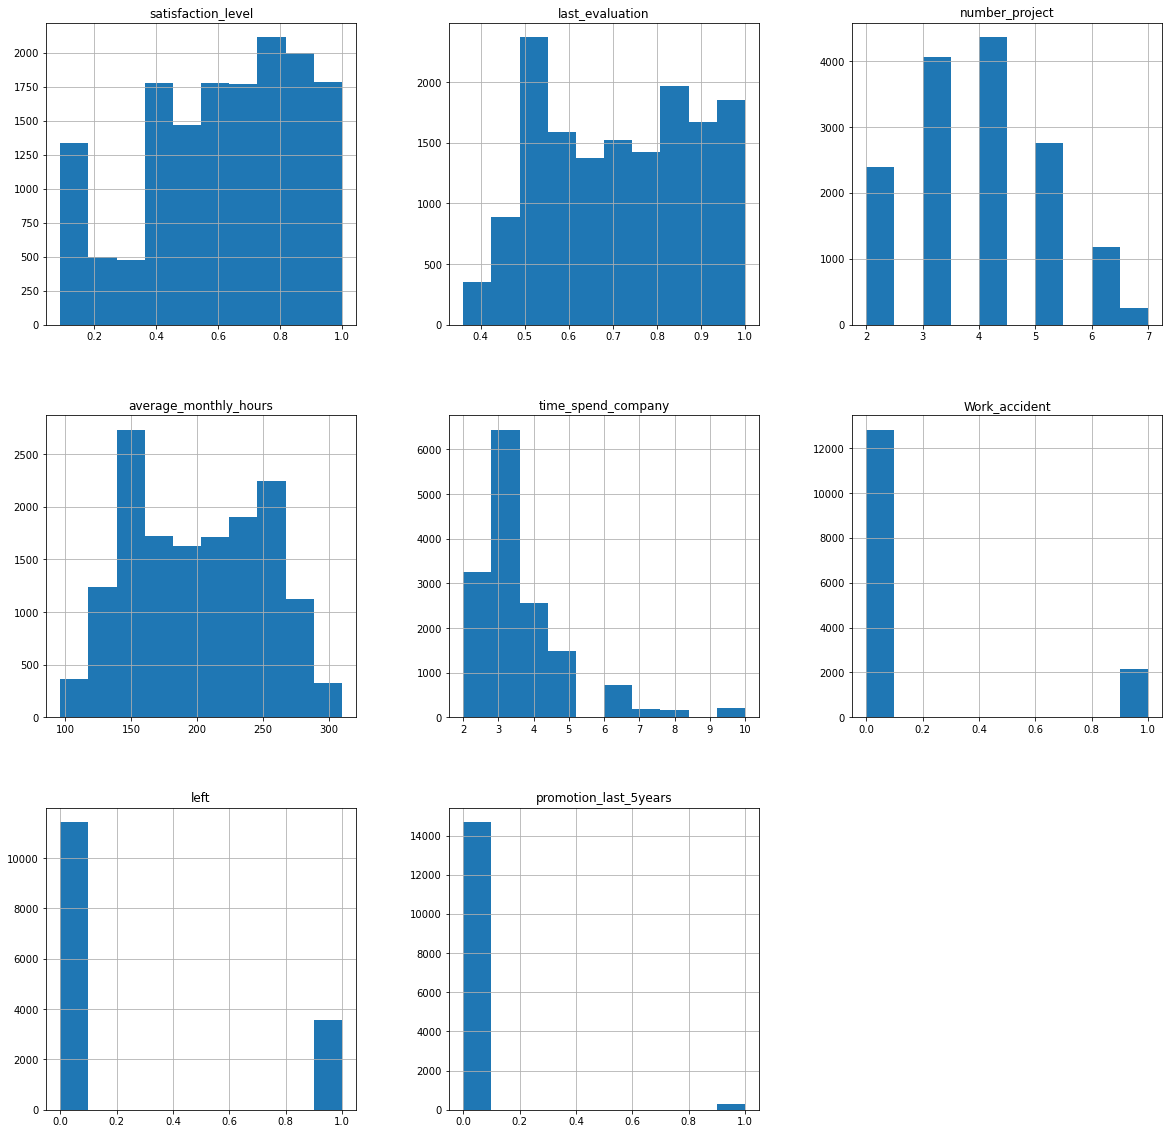

In [8]:
employee_df.hist(figsize=(20,20))

## Feature Selection

In [9]:
# Splitting the dataset for further analysis
left_df = employee_df[employee_df['left'] == 1]
stayed_df = employee_df[employee_df['left'] == 0]

In [10]:
left_df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.0,3571.000000
mean,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,1.0,0.005321
std,0.263933,0.197673,1.818165,61.202825,0.977698,0.212364,0.0,0.072759
min,0.090000,0.450000,2.000000,126.000000,2.000000,0.000000,1.0,0.000000
25%,0.130000,0.520000,2.000000,146.000000,3.000000,0.000000,1.0,0.000000
50%,0.410000,0.790000,4.000000,224.000000,4.000000,0.000000,1.0,0.000000
75%,0.730000,0.900000,6.000000,262.000000,5.000000,0.000000,1.0,0.000000
max,0.920000,1.000000,7.000000,310.000000,6.000000,1.000000,1.0,1.000000


In [11]:
stayed_df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,11428.000000,11428.000000,11428.000000,11428.000000,11428.000000,11428.000000,11428.0,11428.000000
mean,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.0,0.026251
std,0.217104,0.162005,0.979884,45.682731,1.562348,0.379991,0.0,0.159889
min,0.120000,0.360000,2.000000,96.000000,2.000000,0.000000,0.0,0.000000
25%,0.540000,0.580000,3.000000,162.000000,2.000000,0.000000,0.0,0.000000
50%,0.690000,0.710000,4.000000,198.000000,3.000000,0.000000,0.0,0.000000
75%,0.840000,0.850000,4.000000,238.000000,4.000000,0.000000,0.0,0.000000
max,1.000000,1.000000,6.000000,287.000000,10.000000,1.000000,0.0,1.000000


We can notice that were more occurences of work accident in the group of employees that stayed than the group that left the company, hence I decided to leave this feature out.

The feature Promotion in the last 5 years also didn't show anything new here and for that I will keep my decision to rule it out as well.

array([[<AxesSubplot:title={'center':'satisfaction_level'}>,
        <AxesSubplot:title={'center':'last_evaluation'}>,
        <AxesSubplot:title={'center':'number_project'}>],
       [<AxesSubplot:title={'center':'average_monthly_hours'}>,
        <AxesSubplot:title={'center':'time_spend_company'}>,
        <AxesSubplot:title={'center':'Work_accident'}>],
       [<AxesSubplot:title={'center':'left'}>,
        <AxesSubplot:title={'center':'promotion_last_5years'}>,
        <AxesSubplot:>]], dtype=object)

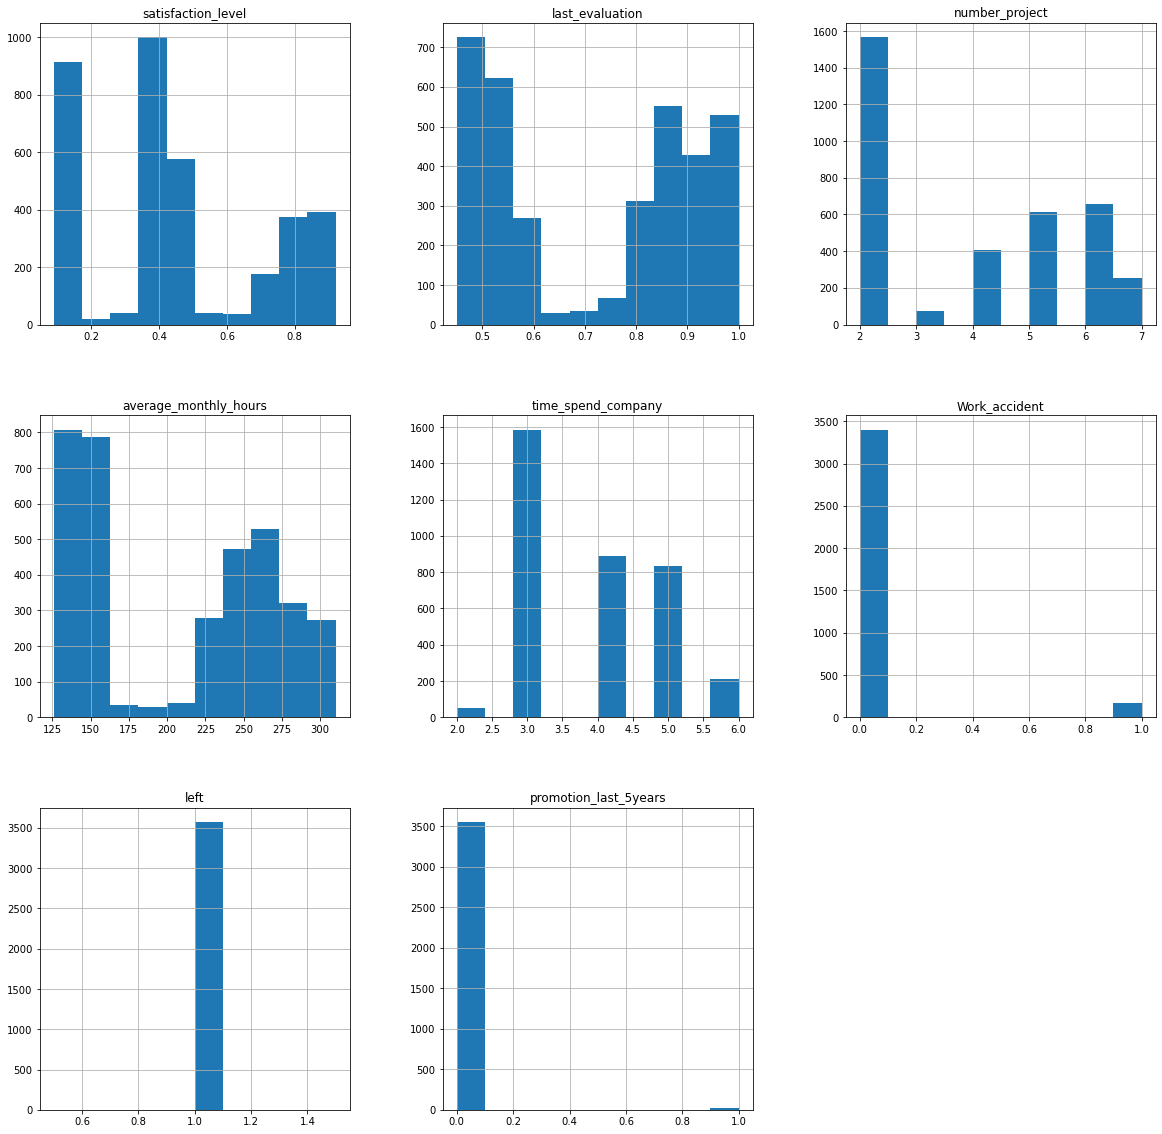

In [12]:
left_df.hist(figsize=(20,20))

array([[<AxesSubplot:title={'center':'satisfaction_level'}>,
        <AxesSubplot:title={'center':'last_evaluation'}>,
        <AxesSubplot:title={'center':'number_project'}>],
       [<AxesSubplot:title={'center':'average_monthly_hours'}>,
        <AxesSubplot:title={'center':'time_spend_company'}>,
        <AxesSubplot:title={'center':'Work_accident'}>],
       [<AxesSubplot:title={'center':'left'}>,
        <AxesSubplot:title={'center':'promotion_last_5years'}>,
        <AxesSubplot:>]], dtype=object)

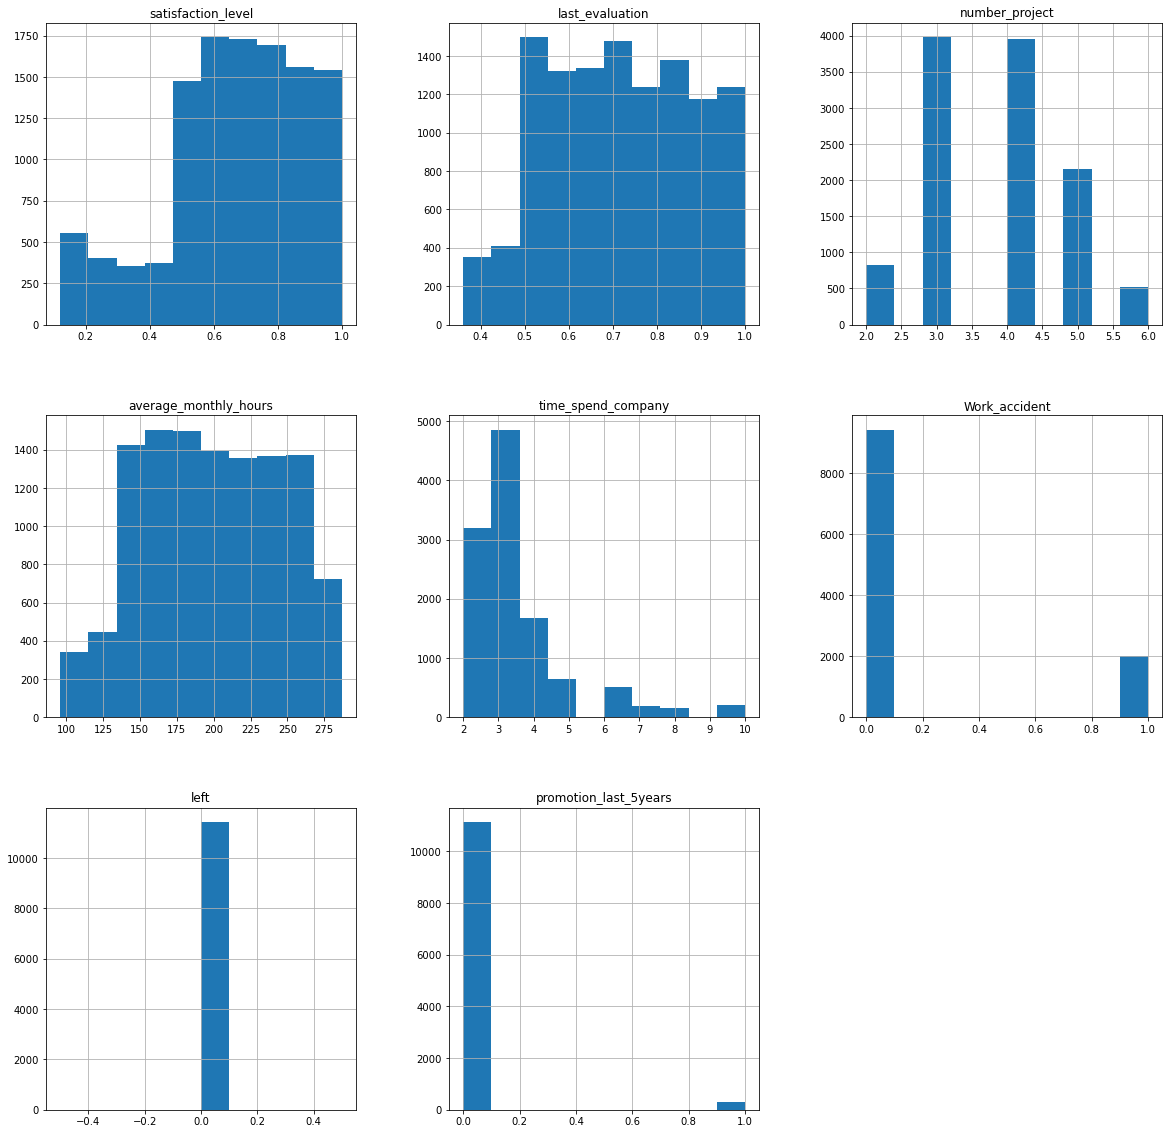

In [13]:
stayed_df.hist(figsize=(20,20))

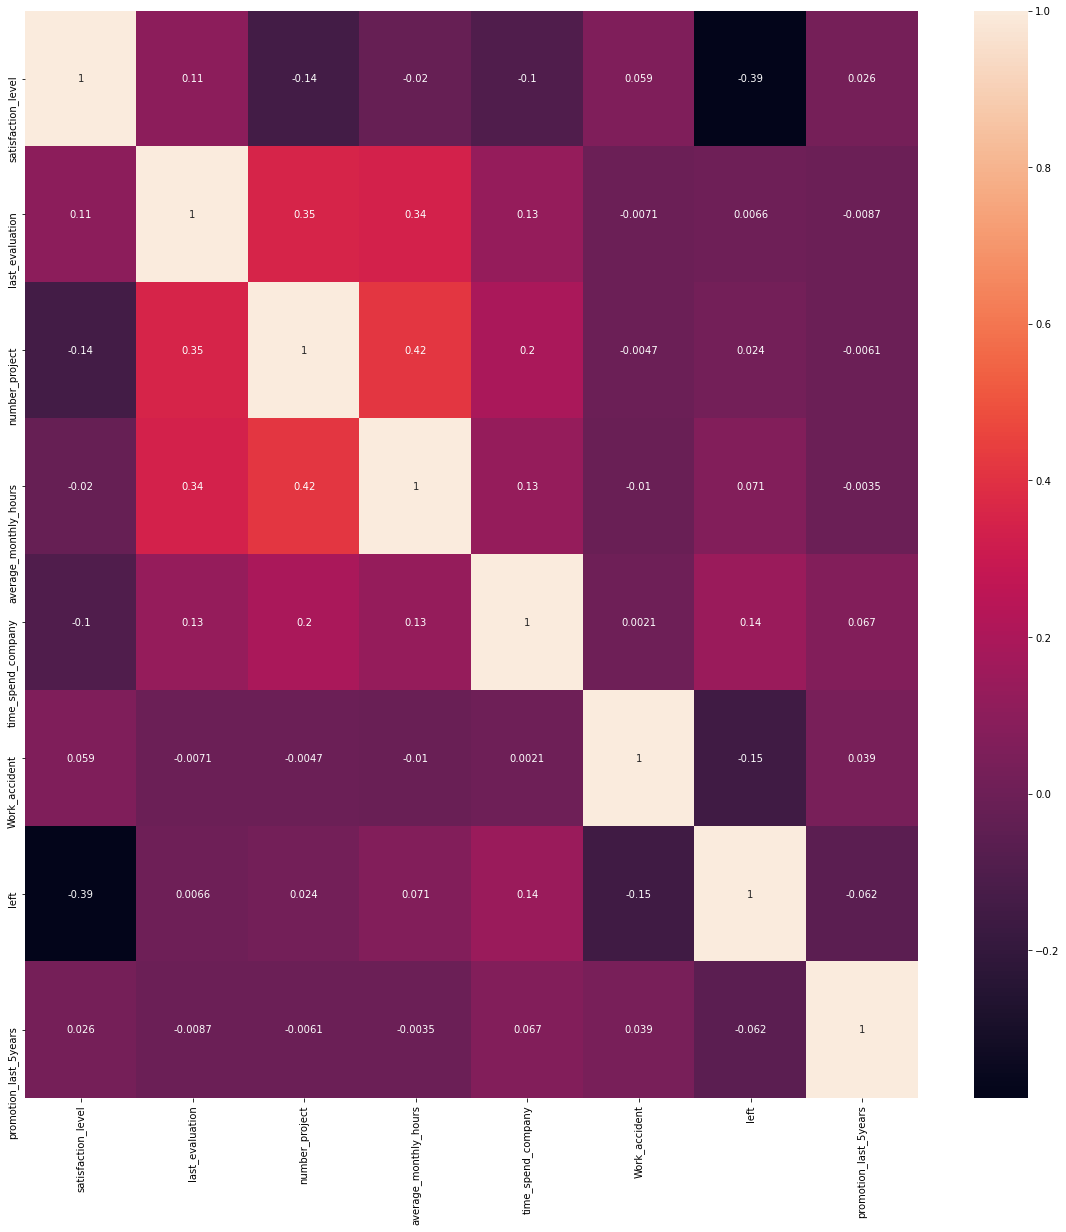

In [14]:
correlations = employee_df.corr()
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(correlations, annot=True);

### Analysing the categorical values

In this plot we can see that the categorical values have a good distribution for making a prediction. I decided to try and run a model with these features, if its the case I can get back for further analysis.

<AxesSubplot:xlabel='salary', ylabel='count'>

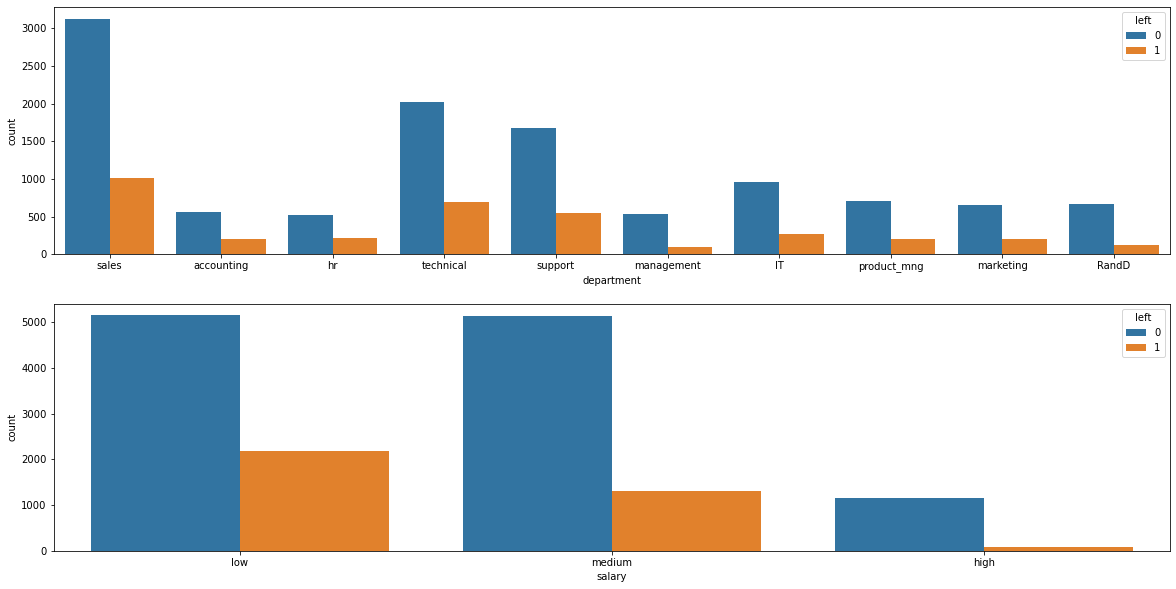

In [15]:
plt.figure(figsize=[20,10])
plt.subplot(211)
sns.countplot(x = 'department', hue = 'left', data = employee_df)
plt.subplot(212)
sns.countplot(x = 'salary', hue = 'left', data = employee_df)

In [16]:
#drop the features that won't be used
employee_df.drop(['promotion_last_5years', 'Work_accident'], axis = 1, inplace=True)
employee_df

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,left,department,salary
0,0.38,0.53,2,157,3,1,sales,low
1,0.80,0.86,5,262,6,1,sales,medium
2,0.11,0.88,7,272,4,1,sales,medium
3,0.72,0.87,5,223,5,1,sales,low
4,0.37,0.52,2,159,3,1,sales,low
...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,1,support,low
14995,0.37,0.48,2,160,3,1,support,low
14996,0.37,0.53,2,143,3,1,support,low
14997,0.11,0.96,6,280,4,1,support,low


In [17]:
# split the dataset
X = employee_df.drop('left', axis=1)
y = employee_df.left

In [18]:
y.shape

(14999,)

In [19]:
X.shape

(14999, 7)

In [20]:
y.value_counts(normalize=True)

0    0.761917
1    0.238083
Name: left, dtype: float64

## Pipeline

The aproach I implemented in this notebook was to create a pipeline for tow main reasons, first, It is easier to perform a cross validation score of all the model building process not only the algorithm and second, the pipeline makes easier to deploy.

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

### Preprocessing

In [44]:
#ColumnTransformer can apply different types of preprocessing methods according to the features nature
#In this case we are scaling the numerical features and creating dummy variables for the categorical ones.
ct = make_column_transformer((OneHotEncoder(), ['department', 'salary']), 
                        (StandardScaler(), make_column_selector(dtype_include=np.number)))

### Fitting the Algorithms

In [45]:
SEED = 10

lr = LogisticRegression(random_state=SEED)
rf = RandomForestClassifier(random_state=SEED)
mlp = MLPClassifier(max_iter=100, random_state=SEED)

In [46]:
pipe_lr = make_pipeline(ct, lr)
pipe_rf = make_pipeline(ct, rf)
pipe_mlp = make_pipeline(ct, mlp)

In [47]:
pipe_lr.fit(X,y)
pipe_rf.fit(X,y)
pipe_mlp.fit(X,y)

/home/rocha/miniconda3/envs/pyenv1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['department', 'salary']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbac5220850>)])),
                ('mlpclassifier',
                 MLPClassifier(max_iter=100, random_state=10))])

## Cross Validation

Since we made the pipeline, cross validation can be very easy. For this dataset the Random Forrest Classifier performed better.

In [48]:
cross_val_score(pipe_lr, X, y).mean()

0.7470414582638657

In [49]:
cross_val_score(pipe_rf, X, y).mean()

0.9911996887851506

In [50]:
cross_val_score(pipe_mlp, X, y).mean()

/home/rocha/miniconda3/envs/pyenv1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rocha/miniconda3/envs/pyenv1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rocha/miniconda3/envs/pyenv1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rocha/miniconda3/envs/pyenv1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warning

0.9657980882516395

## Deploy

This model was downloaded in the folder of the project and will be used in the API file.

In [51]:
import joblib as jb
jb.dump(pipe_rf, 'model.pkl.z')

['model.pkl.z']

In [60]:
pred = pd.DataFrame([[0.45, 0.52, 2, 140, 3, 'sales', 'low']])
pred.rename(columns={0:'satisfaction_level', 1:'last_evaluation', 2:'number_project',
                     3:'average_monthly_hours', 4:'time_spend_company', 5:'department', 6:'salary'}, inplace=True)

In [63]:
pipe_rf.predict(pred)[0]


1

In [58]:
X_new = X.sample(n=5, axis=0, random_state=10)
X_new

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,department,salary
13982,0.65,0.40,5,125,4,sales,low
822,0.41,0.50,2,128,3,management,low
13751,0.44,0.41,3,125,7,sales,medium
9656,0.93,0.44,5,190,5,technical,medium
13497,0.76,0.82,4,170,6,sales,medium


In [41]:
type(pred)

numpy.ndarray